# Reading and understanding the data

In [1]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from chemception.chemception import Chemception
from chemception.Featurizer import ChemCeptionizer
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau

train_df = pd.read_csv('data/train_aid686978.csv')
# train_df = train_df.sample(frac=0.2)
train_df.head()

,smiles,label
0,O=C(CON=Cc1ccccc1OC(F)F)NC1CCCCC1,0.0
1,COc1ccccc1CONC=NC(=O)c1c(OC)ccnc1Oc1ccc(F)cc1,0.0
2,CCCN(CC(=O)Nc1ccc(Cl)cc1Cl)C(=O)C=Cc1cc(OC)ccc1OC,1.0
3,CCOCCn1c(=NC(=O)CSCC(=O)N2CCOCC2)sc2cc(OC)ccc21,0.0
4,COCCNC(=O)C(C#N)=CC=Cc1ccccc1[N+](=O)[O-],1.0


`SMILES` are a way to represent molecules as strings. This represenation is a standard in the Chemistry community and is usually parsed to other representaions of the molecule. For example, the `RDKit` library can parse SMILES to a `Mol` object.

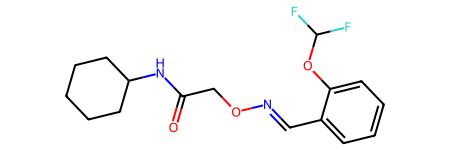

In [2]:
Chem.MolFromSmiles(train_df['smiles'].iloc[0])

We will use this represntation as a first step for our featurization. We will use the `RDKit` library to parse the SMILES to a `Mol` object for all the data.

In [3]:
train_df["mol"] = train_df["smiles"].apply(Chem.MolFromSmiles)

# Featurizing

The featurization process is the backbone of the paper we adopted, the paper chose certain feature that well describe the molecule and used them as features for the model. Which is inline with what we have learned in picking features for our data.

Since we are using a `CNN` Model, our featurization method will be dependent on an image represtnation of the molecule. However, we do some feature engineering that extract important aspects of the molecule (`bonds order`, `atom types`, `hybridization`, and `gasteiger charges`) and use them as features for our model.


![Alt text](images/Featurizer.png)

In [4]:
# This is the featurizer we used, can be found in Featurizer.py
featureizer = ChemCeptionizer(embed=25)

# Featurize the molecules
train_df["molimage"] = train_df["mol"].apply(featureizer.featurize)
# pd.to_pickle(train_df, "train_df.pkl")

# train_df = pd.read_pickle("train_df.pkl")


### Visualize the results of the featurization process

In [5]:
# def show_channel(v, channel_ind):
#     """
#     Show a single channel of a 3D numpy array
#     """
#     v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
#     if channel_ind >= 3:
#         v_copy[:,:,0] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
#     else:
#         v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
        
#     return v_copy


# sample = train_df["molimage"].iloc[1]
# plt.imshow(sample)
# ch1, ch2, ch3 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2)
# fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# ax[0, 0].imshow(ch1)
# ax[0, 1].imshow(ch2)
# ax[1, 0].imshow(ch3)
# # ax[1, 1].imshow(ch4)
# ax[0, 0].set_title("Bond Channel")
# ax[0, 1].set_title("Atomic Number Channel")
# ax[1, 0].set_title("Hybridization Channel")
# # ax[1, 1].set_title("Gasteiger Charge Channel")

Text(0.5, 1.0, 'Molecule')

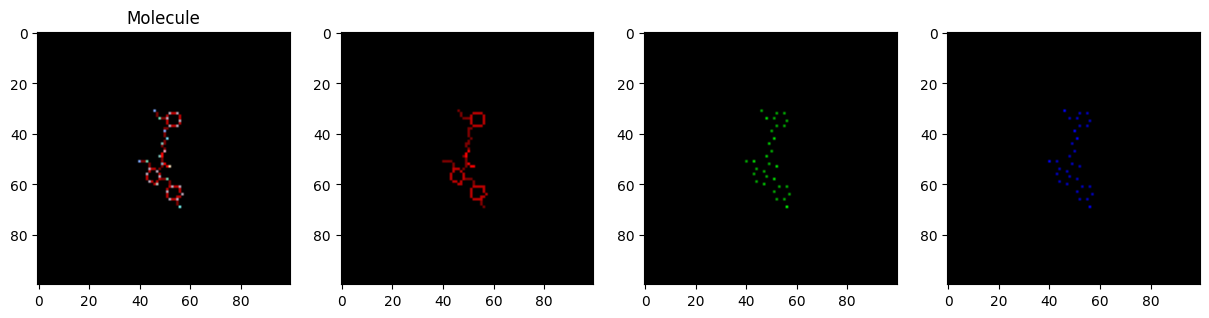

In [6]:
def show_channel(v, channel_ind):
    """
    Show a single channel of a 3D numpy array
    """
    v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
    if channel_ind >= 3:
        v_copy[:,:,0] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
    else:
        v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
        
    return v_copy


sample = train_df["molimage"].iloc[1]
ch1, ch2, ch3 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2)
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(sample)
ax[1].imshow(ch1)
ax[2].imshow(ch2)
ax[3].imshow(ch3)
ax[0].set_title("Molecule")

# ax[1, 1].set_title("Gasteiger Charge Channel")

The featurization is working correctly, we proceed to model building

# Model Building

The model was adpoted directly from the paper with `N` being selected as `32`

### `Block Architecture`
![Alt text](images/model_block_arch.png)

In [7]:
# from keras.optimizers import Adam
# model = Chemception(N=256, reductionA_count=0, reductionB_count=0)
# model = model.build()
# model.compile(optimizer=Adam(learning_rate=.05), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

# Preparing generator and data for fitting

![Alt text](images/Featurizer.png)
It can be observed from the above image the orientation difference between the original image and our featurization result. Since our featurization method in recontructing the molecule image using our selected features, we can assure the `0` intra-class variation, hence, we do not need augmentation.

In [8]:
# import keras
# from keras.layers import Flatten

# def Inception0(input):
#     tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
#     tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
#     tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
 
#     output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
#     return output

# def Inception(input):
#     tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
#     tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
#     tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
#     tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
#     tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
 
#     output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
#     return output



# input_img = Input(shape=X_train.shape[1:])
 
# x = Inception0(input_img)
# x = Inception(x)
# x = Inception(x)
# od=int(x.shape[1])
# x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
# x = Flatten()(x)
# x = Dense(100, activation='relu')(x)
# output = Dense(1, activation='sigmoid')(x)
 
# model = Model(inputs=input_img, outputs=output)
# optimizer = Adam(lr=0.00025)
# model.compile(loss="binary_crossentropy", optimizer=optimizer)
# model.summary()

In [9]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(data_format='channels_last')

train_df.dropna(subset=["molimage"], inplace=True)
X_train = train_df["molimage"].to_numpy()
X_train = np.stack(X_train, axis=0)
y_train = train_df["label"]

batch_size=32
g = generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True)



# Fit the model

#### Load validation data

In [10]:
val_df = pd.read_csv('data/val_aid686978.csv')
# val_df = val_df.sample(frac=0.2)
val_df['mol'] = val_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
val_df['molimage'] = val_df['mol'].apply(featureizer.featurize)
val_df.dropna(subset=["molimage"], inplace=True)
X_val = val_df["molimage"].to_numpy()
X_val = np.stack(X_val, axis=0)
y_val = val_df["label"]

##### Optimal config from hyperband and baysian optimization
{'config': {'dense_layers': 3,
  'dropout': 0.2,
  'embed': 25,
  'lr': 5e-06,
  'neurons': 256},
 'config_info': {'model_based_pick': True}}

In [11]:
from chemception.chemception_transfer import Chemception
from keras.optimizers import Adam
model = Chemception(neurons=256, dropout=0.2, dense_layers=3, img_size=100)
model = model.build()
model.compile(optimizer=Adam(learning_rate= 0.5e-6), loss='binary_crossentropy', metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [12]:
model.fit(g, epochs=50, steps_per_epoch=len(X_train)/batch_size, validation_data=(X_val, y_val))

Epoch 1/50


2023-04-25 01:06:23.314042: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


272/272 [==============================] - 15s 45ms/step - loss: 0.7265 - accuracy: 0.4809 - val_loss: 0.7040 - val_accuracy: 0.4722
Epoch 2/50
272/272 [==============================] - 10s 35ms/step - loss: 0.7268 - accuracy: 0.4812 - val_loss: 0.7027 - val_accuracy: 0.4802
Epoch 3/50
272/272 [==============================] - 9s 35ms/step - loss: 0.7246 - accuracy: 0.4764 - val_loss: 0.7014 - val_accuracy: 0.4813
Epoch 4/50
272/272 [==============================] - 9s 34ms/step - loss: 0.7176 - accuracy: 0.4896 - val_loss: 0.7003 - val_accuracy: 0.4914
Epoch 5/50
272/272 [==============================] - 9s 34ms/step - loss: 0.7156 - accuracy: 0.5008 - val_loss: 0.6993 - val_accuracy: 0.4909
Epoch 6/50
272/272 [==============================] - 9s 34ms/step - loss: 0.7144 - accuracy: 0.4991 - val_loss: 0.6983 - val_accuracy: 0.4909
Epoch 7/50
272/272 [==============================] - 9s 35ms/step - loss: 0.7120 - accuracy: 0.4982 - val_loss: 0.6972 - val_accuracy: 0.4930
Epoch 8/

KeyboardInterrupt: 

In [ ]:

# steps_per_epoch = X_train.shape[0]//batch_size
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)


# history = model.fit(g,
#                     steps_per_epoch=steps_per_epoch,
#                     epochs=100, verbose=2,
#                     validation_data=(X_val, y_val),
#                     callbacks=[reduce_lr]
#                     )

# Plot the history

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'loss')
plt.legend()
plt.yscale("log")

NameError: name 'history' is not defined

# Test the model on test data

In [ ]:
test_df = pd.read_csv('data/test_aid686978.csv')
# test_df = test_df.sample(frac=0.2)
test_df['mol'] = test_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
test_df['molimage'] = test_df['mol'].apply(featureizer.featurize)
test_df.dropna(subset=["molimage"], inplace=True)
X_test = np.array(list(test_df["molimage"]))
y_test = test_df["label"]

[19:29:03] WARNING: not removing hydrogen atom without neighbors


In [ ]:
model.evaluate(X_test, y_test)

58/58 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5033


[0.693132221698761, 0.5032538175582886]

# Kernel Visualization

# Comparing other models

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from deepchem.feat import CircularFingerprint

featurizer = CircularFingerprint(size=1024)
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_val, y_val = featurizer.featurize(val_df["smiles"]), val_df["label"]
X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/miniconda3/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
[19:29:29] WARNING: not removing hydrogen atom without neighbors


0.6751626898047722

### Graph Convolutional Network

In [ ]:
from deepchem.models import GraphConvModel
from deepchem.feat import ConvMolFeaturizer

featurizer = ConvMolFeaturizer()
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_val, y_val = featurizer.featurize(val_df["smiles"]), val_df["label"]
X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

model = GraphConvModel(n_tasks=1, mode='classification', dropout=0.2)
model.fit(X_train, y_train, nb_epoch=100)


model.evaluate(X_test, y_test)

[19:30:00] WARNING: not removing hydrogen atom without neighbors


TypeError: fit() got multiple values for argument 'nb_epoch'